## Spam Email Classifier with KNN using TF-IDF scores

1.   Assignment must be implemented in Python 3 only.
2.   You are allowed to use libraries for data preprocessing (numpy, pandas, nltk etc) and for evaluation metrics, data visualization (matplotlib etc.).
3.   You will be evaluated not just on the overall performance of the model and also on the experimentation with hyper parameters, data prepossessing techniques etc.
4.   The report file must be a well documented jupyter notebook, explaining the experiments you have performed, evaluation metrics and corresponding code. The code must run and be able to reproduce the accuracies, figures/graphs etc.
5.   For all the questions, you must create a train-validation data split and test the hyperparameter tuning on the validation set. Your jupyter notebook must reflect the same.
6.   Strict plagiarism checking will be done. An F will be awarded for plagiarism.

**Task: Given an email, classify it as spam or ham**

Given input text file ("emails.txt") containing 5572 email messages, with each row having its corresponding label (spam/ham) attached to it.

This task also requires basic pre-processing of text (like removing stopwords, stemming/lemmatizing, replacing email_address with 'email-tag', etc..).

You are required to find the tf-idf scores for the given data and use them to perform KNN using Cosine Similarity.

### Import necessary libraries

In [56]:
import numpy as np
import pandas as pd
import re
import nltk
import math
import matplotlib.pyplot as plt
from sklearn import metrics
# from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize,pos_tag
nltk.download("stopwords")
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [57]:
from nltk.stem import PorterStemmer

def stemming(text):
    porter = PorterStemmer()
    
    result=[]
    for word in text:
        result.append(porter.stem(word))
    return result
print(stemming(["running","ran","run"]))

['run', 'ran', 'run']


In [58]:
! pip install pyspellchecker 
# ! pip install indexer 

In [59]:
from spellchecker import SpellChecker
# from indexer import DictionaryIndex
def spell_check(text):
    result = []
    spell = SpellChecker()
    for word in text:
        correct_word = spell.correction(word)
        result.append(correct_word)
    return " ".join(result)

#Test
text = "confuson matrx".split() 
spell_check(text)

'confusion matrix'

In [60]:

def lemmatization(text):
    ''' Takes list of words as input 
    first does POS tagging and then lemmatizes the text.'''
    result=[]
    wordnet = WordNetLemmatizer()
    for token,tag in pos_tag(text):
        pos=tag[0].lower()
        
        if pos not in ['a', 'r', 'n', 'v']:
            pos='n'
            
        result.append(wordnet.lemmatize(token,pos))
    
    return result
def isWord(word):
    if len(word) >1:
      return True
    return False
words=["hello","a","as","qwerty"]
words=list(filter(isWord,words))
print(words)
# print(lemmatization(['run','running','ran']))

['hello', 'as', 'qwerty']


### Load dataset

In [61]:
input_data=[]
labels_data=[]
# with open('emails.txt', 'r') as inFile:
#     input_data = inFile.readlines()

# https://stackoverflow.com/a/47091490/4084039
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

with open('emails.txt', 'r') as f:
  for line in f:
      line=decontracted(line)
      line=line.lower() 
      
      # removing words with numbers
      line=re.sub("\S*\d\S*", "",line)

      # removing special characters
      line=re.sub('[^A-Za-z0-9]+', ' ',line)
      
      # remove urls from text python: https://stackoverflow.com/a/40823105/4084039
      # line = re.sub(r"http\S+", "", line)
      line = re.sub(r"https?://\S+|www\.\S+", "", line)
      # removing stop words
      for sw in stop_words:
        line.replace(sw,"")
      # removing single character words
      words=list(filter(isWord,line.split()))
      labels_data.append(words[0])
      input_data.append(lemmatization(words[1:]))
# print(words[0])
# print(len(input_data))
# print(len(labels_data))
# print(input_data[:5])
# print(input_data)

# np.char.lower(input_data)

In [62]:
total=set()
for sentence in input_data:
    total=total.union(set(sentence))
print(len(total))

6583


In [63]:
print(input_data[1])
word_count_list=[]
for sentence in input_data:
  word_dict=dict.fromkeys(set(sentence), 0) 
  # word_dict=dict.fromkeys(total, 0) 
  for word in sentence:
    word_dict[word]+=1
  word_count_list.append(word_dict)
# print(len(word_count_list[3]))
print(word_count_list[1])


['ok', 'lar', 'joking', 'wif', 'oni']
{'oni': 1, 'wif': 1, 'joking': 1, 'lar': 1, 'ok': 1}


In [64]:
def computeTF(word_count_dict):
  word_count=0
  # calculating word count
  for key in word_count_dict:
    word_count+=word_count_dict[key]
   
  # modifying each pair <word,count> to <word,tf> 
  for word,count in word_count_dict.items():
    word_count_dict[word]=count/word_count
  return word_count_dict
# tf_word_count_list=word_count_list.copy()
# word_count_list.clear()
tf_word_count_list=[]
for word_dict in word_count_list:
   tf_word_count_list.append(computeTF(word_dict))
# print(computeTF(word_count_list[3]))
print(tf_word_count_list[1])

{'oni': 0.2, 'wif': 0.2, 'joking': 0.2, 'lar': 0.2, 'ok': 0.2}


In [65]:
def computeIDF(word_count_dict,total):
  doc_count=len(word_count_dict)
  word_IDF_value=dict.fromkeys(total,0)
  
  # counting the occurances of each unique word in the corpus
  # for word in total:
  for dic in word_count_dict:
    # if word in dic.keys():
    for word in dic.keys():
      word_IDF_value[word]+=1

  # calculating idf value of each word
  for word,value in word_IDF_value.items():
    word_IDF_value[word]=np.log(doc_count/(1 + float(value)))
  return word_IDF_value


In [66]:
labels_data=[1 if x=="spam" else 0 for x in labels_data]

In [67]:
word_IDF_value=computeIDF(tf_word_count_list,total)
tfidf_word_count_list=tf_word_count_list.copy()
tf_word_count_list.clear()
# Changing the pair<word,tf> to <word,tf*idf> values for all dicts in word_count_list
for word_dict in tfidf_word_count_list:
  for word,tf in word_dict.items():
    word_dict[word]=tf*word_IDF_value[word]

df=pd.DataFrame(tfidf_word_count_list)
df=df.fillna(0)

# df['LABELS_']=labels_data
# df.drop_duplicates(inplace=True)
# labels_data=df['LABELS_']
# print(len(labels_data))
# df.drop('LABELS_', axis=1, inplace=True)
# print(df.shape)

In [68]:
df.head()

,until,la,available,only,wat,there,go,jurong,get,buffet,in,crazy,cine,great,point,bugis,world,amore,oni,wif,joking,lar,ok,cup,may,free,comp,receive,to,be,apply,entry,txt,rate,text,wkly,final,fa,std,win,...,endless,reassure,young,referin,colany,saibaba,chic,declare,disappointment,irritation,tantrum,compliment,chief,gsex,attached,chatlines,bailiff,servs,inclu,desk,mouse,childporn,belt,cribbs,jumper,spiritual,influx,sudden,kane,shud,pshew,accent,nmde,dental,unit,heap,dump,salesman,pity,bitching
0,0.294092,0.36369,0.315635,0.182953,0.22173,0.180588,0.133077,0.440707,0.120418,0.418181,0.107089,0.328768,0.36369,0.218584,0.283306,0.36369,0.277127,0.440707,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,1.403286,1.066006,1.505451,0.997656,0.597503,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.077104,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.252931,0.187762,0.127686,0.242437,0.194587,0.143348,0.065729,0.20398,0.442786,0.141531,0.194587,0.133303,0.236713,0.227257,0.60218,0.245638,0.148235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.184261,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.091890,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Preprocess data

### Split data

In [69]:
from numpy import dot
from numpy.linalg import norm
def eucliedian_distance(point1,point2):
  dist = np.linalg.norm(point1 - point2)
  return dist

def manhattan_distance(point1,point2):
  dist= np.abs(point1-point2).sum()
  return dist

def cosine_similarity(a,b,c):
  cos_sim = dot(a, b)/(c*norm(b))
  return cos_sim

def hamming_distance(point1,point2):
  dist= np.abs(point1-point2).sum()
  return dist/len(total)

Train Test Validation

In [70]:
from sklearn.model_selection import train_test_split
x_train,x_,y_train,y_ = train_test_split(df,labels_data,test_size=0.3, random_state=25)
x_test,x_valid,y_test,y_valid=train_test_split(x_,y_,test_size=0.66, random_state=25)

In [71]:
print(x_test.shape)
print(x_train.shape)
print(x_valid.shape)

(568, 6583)
(3901, 6583)
(1105, 6583)


In [72]:
x_test_np=x_test.to_numpy()
x_train_np=x_train.to_numpy()
x_valid_np=x_valid.to_numpy()
print(x_test_np.shape)
print(type(x_test_np[0]))
print(type(x_test_np))

(568, 6583)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [73]:
x_test_rows,_=(x_test_np).shape
x_train_rows,_=(x_train_np).shape
x_valid_rows,_=(x_valid_np).shape
print(x_test_rows,x_train_rows,x_valid_rows)

568 3901 1105


In [74]:
def knn_cosine_similarity(knn_list,x_valid_rows,x_valid_np):
  all_k_predictions=[]
  for i in range(x_valid_rows):
    distances=[]
    test_value = norm(x_valid_np[i])
    for j in range(x_train_rows):
      dist=cosine_similarity(x_valid_np[i],x_train_np[j],test_value)
      distances.append([dist,y_train[j]]) 
    distances.sort(key=lambda x:x[0],reverse=True)
    computed_test_labels=[]
    for knn in knn_list:
      spam,ham=0,0
      for num in range(knn):
        if(distances[num][1]==0):
          ham+=1
        else:
          spam+=1
      if(ham<spam):
        computed_test_labels.append(1)
      else:
        computed_test_labels.append(0)
    all_k_predictions.append(computed_test_labels)
    # print(computed_test_labels)
  all_k_predictions=np.array([np.array(xi) for xi in all_k_predictions])
  all_k_predictions=all_k_predictions.transpose()
  print(all_k_predictions.shape)
  return all_k_predictions
  # print(len(computed_test_labels))


In [75]:
def manhattan_similarity(knn_list):
  all_k_predictions=[]
  for i in range(x_valid_rows):
    distances=[]
    # test_value = norm(x_valid_np[i])
    for j in range(x_train_rows):
      dist=manhattan_distance(x_valid_np[i],x_train_np[j])
      distances.append([dist,y_train[j]]) 
    distances.sort(key=lambda x:x[0])
    computed_test_labels=[]
    for knn in knn_list:
      spam,ham=0,0
      for num in range(knn):
        if(distances[num][1]==0):
          ham+=1
        else:
          spam+=1
      if(ham<spam):
        computed_test_labels.append(1)
      else:
        computed_test_labels.append(0)
    all_k_predictions.append(computed_test_labels)
    # print(computed_test_labels)
  all_k_predictions=np.array([np.array(xi) for xi in all_k_predictions])
  all_k_predictions=all_k_predictions.transpose()
  print(all_k_predictions.shape)
  return all_k_predictions
  # print(len(computed_test_labels))

In [76]:
def knn_euclidean_similarity(knn_list):
  all_k_predictions=[]
  for i in range(x_valid_rows):
    distances=[]
    # test_value = norm(x_valid_np[i])
    for j in range(x_train_rows):
      dist=eucliedian_distance(x_valid_np[i],x_train_np[j])
      distances.append([dist,y_train[j]]) 
    distances.sort(key=lambda x:x[0])
    computed_test_labels=[]
    for knn in knn_list:
      spam,ham=0,0
      for num in range(knn):
        if(distances[num][1]==0):
          ham+=1
        else:
          spam+=1
      if(ham<spam):
        computed_test_labels.append(1)
      else:
        computed_test_labels.append(0)
    all_k_predictions.append(computed_test_labels)
    # print(computed_test_labels)
  all_k_predictions=np.array([np.array(xi) for xi in all_k_predictions])
  all_k_predictions=all_k_predictions.transpose()
  print(all_k_predictions.shape)
  return all_k_predictions
  # print(len(computed_test_labels))

In [77]:
print(eucliedian_distance(x_valid_np[0],x_train_np[0]))

1.4134854899848566


In [78]:
k_values_list=[1,3,5,7,17,23,28]

In [79]:
all_k_predictions_cosine=knn_cosine_similarity(k_values_list,x_valid_rows,x_valid_np)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


(7, 1105)


In [80]:
all_k_predictions_eucledian=knn_euclidean_similarity(k_values_list)

(7, 1105)


In [81]:
all_k_predictions_manhattan=manhattan_similarity(k_values_list)

(7, 1105)


In [82]:
all_k_predictions_manhattan[:10]

array([[1, 1, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [83]:
all_k_predictions_cosine.shape

(7, 1105)

In [84]:

def create_conf_matrix(true_values,predictions):
  classes = set(true_values)
  number_of_classes = len(classes)

  conf_matrix = pd.DataFrame(
      np.zeros((number_of_classes, number_of_classes),dtype=int),
      index=classes,
      columns=classes)

  for true_label, prediction in zip(true_values ,predictions):
      # Each pair of (true_label, prediction) is a position in the confusion matrix (row, column)
      # Basically here we are counting how many times we have each pair.
      # The counting will be placed at the matrix index (true_label/row, prediction/column)
  
      conf_matrix.loc[true_label, prediction] += 1
  print(conf_matrix.values)
  tn=conf_matrix.iloc[0][0]
  fp=conf_matrix.iloc[0][1]
  fn=conf_matrix.iloc[1][0]
  tp=conf_matrix.iloc[1][1]
  # Precision = TP / (TP+FP)
  # Recall = TP / (TP+FN)
  # f1_score= 2*((precision*recall)/(precision+recall))
  precision=tp/(tp+fp)
  recall=tp/(tp+fn)
  f1_score= 2*((precision*recall)/(precision+recall))
  accuracy=(tn+tp)/(tn+tp+fp+fn)
  # print(precision,recall,f1_score,accuracy)
  return [precision,recall,f1_score,accuracy]

In [85]:
def conf_matix_sklearn(true_values,predictions):
  tn, fp, fn, tp = metrics.confusion_matrix(true_values, predictions).ravel()
  precision=tp/(tp+fp)
  recall=tp/(tp+fn)
  f1_score= 2*((precision*recall)/(precision+recall))
  accuracy=(tn+tp)/(tn+tp+fp+fn)
  # print(precision,recall,f1_score,accuracy)
  return [precision,recall,f1_score,accuracy]

***1. Experiment with different distance measures [Euclidean distance, Manhattan distance, Hamming Distance] and compare with the Cosine Similarity distance results.***

In [86]:
true_values=np.array(y_valid)
f1_scores_all_metrics=[]
for values in [all_k_predictions_cosine,all_k_predictions_eucledian,all_k_predictions_manhattan]:
  all_confusion_matrix=[]
  f1_score_values=[]
  for k,predictions in zip(k_values_list,values):
    x=[k]
    x.extend(create_conf_matrix(true_values,predictions))
    # x=conf_matix_sklearn(true_values,predictions)
    all_confusion_matrix.append(x)
    f1_score_values.append(x[2])
  f1_scores_all_metrics.append(f1_score_values)
  result_df = pd.DataFrame(all_confusion_matrix,columns=["k_value","precision","recall","f1_score","accuracy"])
  print(result_df)

[[931  11]
 [ 28 135]]
[[935   7]
 [ 30 133]]
[[936   6]
 [ 33 130]]
[[938   4]
 [ 31 132]]
[[939   3]
 [ 54 109]]
[[939   3]
 [ 67  96]]
[[939   3]
 [ 81  82]]
   k_value  precision    recall  f1_score  accuracy
0        1   0.924658  0.828221  0.873786  0.964706
1        3   0.950000  0.815951  0.877888  0.966516
2        5   0.955882  0.797546  0.869565  0.964706
3        7   0.970588  0.809816  0.882943  0.968326
4       17   0.973214  0.668712  0.792727  0.948416
5       23   0.969697  0.588957  0.732824  0.936652
6       28   0.964706  0.503067  0.661290  0.923982
[[393 549]
 [  0 163]]
[[931  11]
 [ 65  98]]
[[935   7]
 [ 90  73]]
[[935   7]
 [105  58]]
[[940   2]
 [128  35]]
[[942   0]
 [134  29]]
[[942   0]
 [146  17]]
   k_value  precision    recall  f1_score  accuracy
0        1   0.228933  1.000000  0.372571  0.503167
1        3   0.899083  0.601227  0.720588  0.931222
2        5   0.912500  0.447853  0.600823  0.912217
3        7   0.892308  0.355828  0.508772  0.898643
4 

In [87]:
predictions_cosine_test=knn_cosine_similarity([7],x_test_rows,x_test_np)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


(1, 568)


### Train your KNN model (reuse previously implemented model built from scratch) and test on your data

***2. Explain which distance measure works best and why? Explore the distance measures and weigh their pro and cons in different application settings.***

* Among the three metrics (Cosine, Eucledian, Manhattan) the best is **Cosine distance.** 
* The reason for this is, cosine distance is better for knowing the semantics of the text. Thus, texts having common meaning are moved towards same direction. 
*  When we vectorize texts, they results in higher dimensions. It is tedious to calculate euclidean distance for such higher dimensions. It is also sensitive to noise because of squared terms.this is known as ‘curse of dimensionality’.
* Manhattan may be appropriate if different dimensions are not comparable.But each dimensionality represent different word which has different meaning and much comparison is possible.

***3. Accuracy, precision, recall, f1 score***

In [88]:
true_values_test=np.array(y_test)
my_built_knn=create_conf_matrix(true_values_test,predictions_cosine_test[0])
print("precision","recall","f1_score","accuracy")
print(my_built_knn)

[[492   2]
 [ 20  54]]
precision recall f1_score accuracy
[0.9642857142857143, 0.7297297297297297, 0.8307692307692307, 0.9612676056338029]


***4. Choose different K values (k=1,3,5,7,11,17,23,28) and experiment. Plot a graph showing f1 score vs k.***

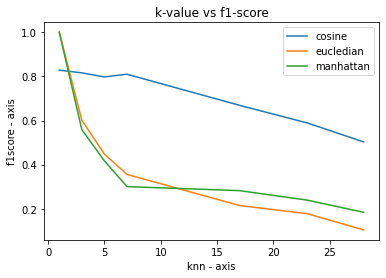

In [89]:
knn_axis = [1,3,5,7,17,23,28]
# plotting the points
plt.plot(knn_axis, f1_scores_all_metrics[0],label="cosine") 
plt.plot(knn_axis, f1_scores_all_metrics[1],label="eucledian")
plt.plot(knn_axis, f1_scores_all_metrics[2],label="manhattan")
# naming the x axis
plt.xlabel('knn - axis')
# naming the y axis
plt.ylabel('f1score - axis')
# giving a title to my graph
plt.title('k-value vs f1-score')
plt.legend()
# function to show the plot
plt.show()


### Train and test Sklearn's KNN classifier model on your data (use metric which gave best results on your experimentation with built-from-scratch model.)

In [90]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=7,metric='cosine')

# Train the model using the training sets
model.fit(x_train_np,y_train)
#Predict Output
predicted_sklearn= model.predict(x_test_np) # 0:Overcast, 2:Mild
# print(predicted)
print(np.equal(true_values_test, np.array(predicted_sklearn)).mean())

0.9577464788732394


***Compare both the models result.***

In [91]:
sklearn_knn=create_conf_matrix(true_values_test,predicted_sklearn)
print("precision","recall","f1_score","accuracy")
print(my_built_knn)
print(sklearn_knn)

[[489   5]
 [ 19  55]]
precision recall f1_score accuracy
[0.9642857142857143, 0.7297297297297297, 0.8307692307692307, 0.9612676056338029]
[0.9166666666666666, 0.7432432432432432, 0.8208955223880596, 0.9577464788732394]


***What is the time complexity of training using KNN classifier?***

Since the knn model is not trained with the test data. The time complexity for training is O(1) 

***What is the time complexity while testing? Is KNN a linear classifier or can it learn any boundary?***